## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [24]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [4]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [49]:
n = 10000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

  0%|          | 0/1000 [00:00<?, ?it/s]

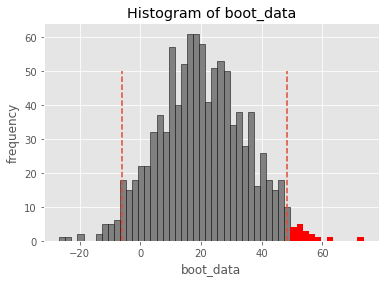

In [50]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [52]:
booted_data["p_value"] # альфа

0.1560685917411612

In [53]:
booted_data["quants"] # ДИ

,0
0.025,-6.031248
0.975,48.198077


In [54]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [55]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [56]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [57]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [58]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [59]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

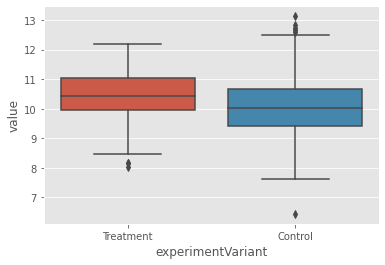

In [60]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

/Users/danilaandreev/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

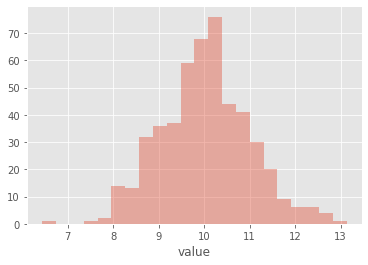

In [61]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

<AxesSubplot:xlabel='value'>

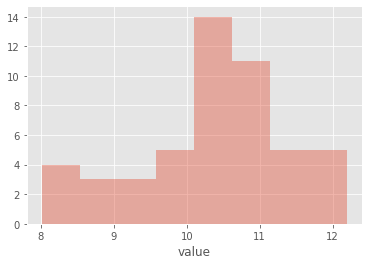

In [62]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [63]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [64]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.331858965573001, pvalue=0.020069539127355422)

  0%|          | 0/10000 [00:00<?, ?it/s]

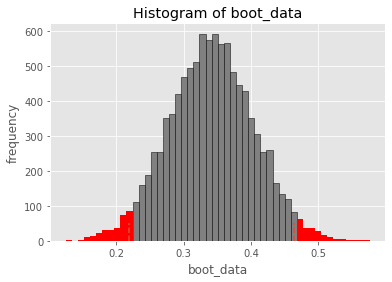

{'boot_data': [0.3170458560353354,
  0.34699938254629487,
  0.45545838686659995,
  0.41273392793614494,
  0.42014742253795395,
  0.1825698559272958,
  0.4395948000866505,
  0.3392739827440812,
  0.27406062409136006,
  0.34486570291296786,
  0.4445903985479933,
  0.3217740766294737,
  0.26095930407467993,
  0.27724883194604655,
  0.35095766008370377,
  0.4384645741307353,
  0.377407949032398,
  0.3915716234970853,
  0.42531143556801204,
  0.3952440288628512,
  0.3218830892540229,
  0.3994653054859683,
  0.3282568110999924,
  0.42450383796206986,
  0.20660192788109327,
  0.28990246821797744,
  0.27354239702619637,
  0.39522958837629985,
  0.33387579296786424,
  0.285621061278576,
  0.29182036396479294,
  0.32791858922817335,
  0.3732675440036398,
  0.3433498151281166,
  0.4238240751680095,
  0.36227767349671136,
  0.3085889991208999,
  0.28386486360713314,
  0.4074061184246577,
  0.33828700261687705,
  0.3497439264406206,
  0.3867300196231595,
  0.43000106329448273,
  0.41691234547928296

In [70]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/10000 [00:00<?, ?it/s]

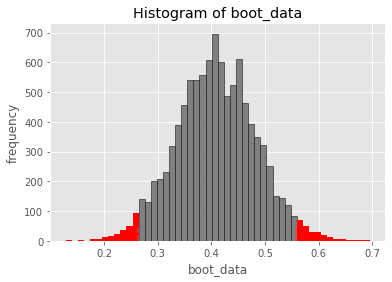

{'boot_data': [0.4720330768499901,
  0.5091685902349603,
  0.4993336366518548,
  0.38061042387772037,
  0.45728220689322985,
  0.40025880809646,
  0.41837119490550023,
  0.32966375549375027,
  0.36674499787149983,
  0.4343379154613052,
  0.3029570388598497,
  0.36567564795489993,
  0.4103250779664007,
  0.39632945720525026,
  0.26917122724705056,
  0.4007460137635004,
  0.3951171555909001,
  0.3461139983034256,
  0.3914601747086497,
  0.45434460589574943,
  0.42498605105580456,
  0.42984025186838526,
  0.44824644641010103,
  0.45775918389094983,
  0.38668196945921984,
  0.2954740240127496,
  0.4360476386426937,
  0.41342252679044567,
  0.3132078395952007,
  0.4225789749882507,
  0.5002305571085053,
  0.49358048582324976,
  0.5166208031695696,
  0.3450448832953352,
  0.35843366283480016,
  0.36497951800717043,
  0.30766197434895126,
  0.3844282352592998,
  0.5238478304322003,
  0.4303883800444508,
  0.5344355600791308,
  0.33064690457531576,
  0.39912132843460046,
  0.40748534526305047,

In [71]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [22]:
5.4687657931866705e-08 < 0.0000002

True